## Expanding a company's reach:
### Where should In-N-Out locate its stores when it chooses to expand to a new city? 

In this notebook, we will use a Machine Learning technique known as k-means clustering in order to determine in which neighborhoods In-N-Out could locate new restaurants in a new city, in this case, Seattle. In order to train the model, we will examine In-N-Out's current locations in three urban areas in California, which is where In-N-Out is based: Los Angeles (very urban), the SF Bay Area (more suburban), and the Central Valley (small cities in rural areas). This will give us the opportunity to look at a wider variety of comparable areas in our exploration of the new area.

Let's start by looking at the dataset.

In [1]:
import pandas as pd
path = 'In_N_Out.csv'

dfs = pd.read_csv(path, header=0)
dfs.head()

,Address,Region,Rand_Sales
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380
4,"761 N. First St. Burbank, CA",LA,1117057


We have the address for the store, the region in which it is located, and a random figure for yearly sales. According to an interview in Forbes magazine with the CEO of In-N-Out (https://bit.ly/2YDBF5W), a store averages approximately 4.5M USD in sales per year. I therefore generated random sales values between 1M USD and 8M USD in Excel, which are located in the column "Rand_Sales". In order to use the Foursquare API to help us get an idea for what kinds of neighborhoods have In-N-Out locations, we need to have the latitude and longitude for the locations. In addition, we might be curious to know a few other bits of information about the area, like population density or per-capita income. The following few blocks of code will get us this information and put it in the dataframe dfs.

We'll start with the information that we can get from geocoder.

In [2]:
import geocoder

ziplist = list()
latlist = list()
lonlist = list()

for x in dfs['Address']:
    g = geocoder.arcgis(str(x))
    add = g.address
    add = add[-5:]
    ziplist.append(add)
    lat = g.lat
    latlist.append(lat)
    long = g.lng
    lonlist.append(long)

In [3]:
zip_df = pd.DataFrame({'Zipcode': ziplist})
lat_df = pd.DataFrame({'Latitude' : latlist})
lon_df = pd.DataFrame({'Longitude' : lonlist}) 
dfs = pd.merge(dfs, zip_df, left_index = True, right_index = True)
dfs = pd.merge(dfs, lat_df, left_index = True, right_index = True)
dfs = pd.merge(dfs, lon_df, left_index = True, right_index = True)
dfs.head()

,Address,Region,Rand_Sales,Zipcode,Latitude,Longitude
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629
4,"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575


**The following code will find the required demographic information for each zipcode.**

In [4]:
from uszipcode import SearchEngine
income_list = list()
density_list = list()

for inc in dfs['Zipcode']:
    inc = str(inc)
    search = SearchEngine(simple_zipcode=True)
    med_income = search.by_zipcode(inc)
    density = med_income.population_density
    med_income = med_income.median_household_income
    income_list.append(med_income)
    density_list.append(density)

inc_df = pd.DataFrame({'Median Income of Zip' : income_list}) 
dfs = pd.merge(dfs, inc_df, left_index = True, right_index = True)

dens_df = pd.DataFrame({'Density of Zip' : density_list})
dfs = pd.merge(dfs, dens_df, left_index = True, right_index = True)

**Ok, now that we have our information, let's have a look at the dataframe.**

In [5]:
print(dfs.shape)
dfs.head()

(116, 8)


,Address,Region,Rand_Sales,Zipcode,Latitude,Longitude,Median Income of Zip,Density of Zip
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654,53027,12101.0
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439,80183,5019.0
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529,55495,353.0
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629,51232,5699.0
4,"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575,40714,8521.0


**Let's view these locations on a map, query Foursquare so that we can see what kind of neighborhoods these places are in, and then cluster the neighborhoods based on the data that we've collected.**

In [6]:
from geopy.geocoders import Nominatim

address = 'California'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

import folium
map_california = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, address, zcode in zip(dfs['Latitude'], dfs['Longitude'], dfs['Address'], dfs['Zipcode']):
    label = '{} \n {}'.format(address, zcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_california)

map_california

**Time to query Foursquare!**

In [7]:
CLIENT_ID = '43BSICSNVD3OVKDGUJ2LZGA241HNFICFPN1TMB3E2EKDMDKC' # your Foursquare ID
CLIENT_SECRET = 'QGHCKAFNEGSRSQ3GANVA3BVF03FHOVLQVO5OWMM2LXJVVZ4Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print("Foursquare Credentials loaded.")

Foursquare Credentials loaded.


**This a function that we defined in order to produce the query to pass to the Foursquare API.**

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 100):
    print("Query in progress! Please wait.")
    import requests
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Restaurant_Address', 
                  'Restaurant_Latitude', 
                  'Restaurant_Longitude', 
                  'Nearby_Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    print("Query complete!")
    return(nearby_venues)


**Now, we'll pass the info from our dataframe to this function so that we can actually run the query.**

In [9]:
innout_nearby_venues = getNearbyVenues(names=dfs['Address'],
                                   latitudes=dfs['Latitude'],
                                   longitudes=dfs['Longitude']
                                  )

Query in progress! Please wait.
Query complete!


**And now, we can visualize the results of our query.**

In [10]:
print(innout_nearby_venues.shape)
innout_nearby_venues.head()

(7023, 7)


,Restaurant_Address,Restaurant_Latitude,Restaurant_Longitude,Nearby_Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,In-N-Out Burger,34.106211,-118.134465,Burger Joint
1,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Z Sushi,34.105726,-118.134464,Sushi Restaurant
2,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Twohey's Restaurant,34.106601,-118.134490,American Restaurant
3,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Ocean Liquor,34.104190,-118.138715,Convenience Store
4,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Pharos Burgers,34.105139,-118.134518,Burger Joint


**Because the query actually (unsurprisingly) found In-N-Outs at the locations specified, we want to drop these from our innout_nearby_venues dataframe, since keeping them in our data would increase the percentage of burger joints in the neighborhood. Remember that we are trying to find places in Seattle where In-n-outs might be best suited to open up. It doesn't make sense for In-N-Out already being there to be a justification for opening a new one up.**

In [11]:
innout_nearby_venues = innout_nearby_venues[innout_nearby_venues.Nearby_Venue != 'In-N-Out Burger']

In [12]:
#innout_nearby_venues = innout_nearby_venues.reset_index()
print(innout_nearby_venues.shape)
innout_nearby_venues.head()

(6908, 7)


,Restaurant_Address,Restaurant_Latitude,Restaurant_Longitude,Nearby_Venue,Venue_Latitude,Venue_Longitude,Venue_Category
1,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Z Sushi,34.105726,-118.134464,Sushi Restaurant
2,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Twohey's Restaurant,34.106601,-118.134490,American Restaurant
3,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Ocean Liquor,34.104190,-118.138715,Convenience Store
4,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,Pharos Burgers,34.105139,-118.134518,Burger Joint
5,"1210 N. Atlantic Blvd. Alhambra, CA",34.106071,-118.134654,YMCA of South Pasadena & San Marino,34.107716,-118.136688,Gym / Fitness Center


**Now we can aggregate the data and center it so we can better compare the locations for clustering. Let's start by seeing how many venues were returned for each restaurant.**

In [13]:
innout_nearby_venues.groupby('Restaurant_Address').count().head()

,Restaurant_Latitude,Restaurant_Longitude,Nearby_Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Restaurant_Address,,,,,,
"1010 Lakeville Hwy, Petaluma, CA",16,16,16,16,16,16
"10525 Carmenita Rd. Santa Fe Springs, CA",51,51,51,51,51,51
"10601 E. Lower Azusa Rd. Temple City, CA",25,25,25,25,25,25
"1090 N. Western Ave. San Pedro, CA",72,72,72,72,72,72
"11 Rollins Rd. Millbrae, CA",97,97,97,97,97,97


**Let's see how many unique venue categories came out of our query.**

In [14]:
print('There are {} unique categories.'.format(len(innout_nearby_venues['Venue_Category'].unique())))

There are 371 unique categories.


In [15]:
# one hot encoding
innout_onehot = pd.get_dummies(innout_nearby_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe and put it at the beginning of the dataframe. 
innout_onehot['Restaurant_Address'] = innout_nearby_venues['Restaurant_Address']
innout_onehot = innout_onehot.set_index('Restaurant_Address')
innout_onehot = innout_onehot.reset_index()

innout_onehot.head()

,Restaurant_Address,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Warehouse Store,Waste Facility,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"1210 N. Atlantic Blvd. Alhambra, CA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"1210 N. Atlantic Blvd. Alhambra, CA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"1210 N. Atlantic Blvd. Alhambra, CA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"1210 N. Atlantic Blvd. Alhambra, CA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"1210 N. Atlantic Blvd. Alhambra, CA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
innout_onehot.shape

(6908, 372)

In [17]:
innout_grouped = innout_onehot.groupby('Restaurant_Address').mean().reset_index()
innout_grouped

,Restaurant_Address,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Warehouse Store,Waste Facility,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"1010 Lakeville Hwy, Petaluma, CA",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"10525 Carmenita Rd. Santa Fe Springs, CA",0.019608,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000
2,"10601 E. Lower Azusa Rd. Temple City, CA",0.000000,0.000000,0.0,0.0,0.0,0.040000,0.000000,0.000000,0.000000,...,0.040000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"1090 N. Western Ave. San Pedro, CA",0.013889,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"11 Rollins Rd. Millbrae, CA",0.010309,0.000000,0.0,0.0,0.0,0.000000,0.010309,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010309
5,"11455 Laurel Canyon Blvd. San Fernando, CA",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"1159 N. Rengstorff Ave. Mountain View, CA",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.022727,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"119 S. Brand Ave. Glendale, CA",0.000000,0.020202,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.020202,0.010101,0.000000,0.000000,0.010101,0.000000
8,"1210 N. Atlantic Blvd. Alhambra, CA",0.058824,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"1261 S. Lone Hill Ave. Glendora, CA",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.013699,0.0,0.0,0.000000,0.000000,0.013699,0.000000,0.013699,0.013699,0.000000


**Okay, let's determine which are the five most frequently occurring venue types surrounding each of these restaurants.**

In [18]:
#To visualize the top five, un-comment and run this cell.
# num_top_venues = 5

# for resto in innout_grouped['Restaurant_Address']:
#     print("----"+resto+"----")
#     temp = innout_grouped[innout_grouped['Restaurant_Address'] == resto].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')

**Alright, let's add all these values to the dataframe we built earlier.**

In [19]:
import numpy as np
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Restaurant Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
innout_venues_sorted = pd.DataFrame(columns=columns)
innout_venues_sorted['Restaurant Address'] = innout_grouped['Restaurant_Address']

for ind in np.arange(innout_grouped.shape[0]):
    innout_venues_sorted.iloc[ind, 1:] = return_most_common_venues(innout_grouped.iloc[ind, :], num_top_venues)

innout_venues_sorted.head()

,Restaurant Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1010 Lakeville Hwy, Petaluma, CA",Convenience Store,Sandwich Place,Plaza,Thrift / Vintage Store,Pet Service,Shipping Store,Dog Run,Pizza Place,Hotel,Video Store
1,"10525 Carmenita Rd. Santa Fe Springs, CA",Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Pharmacy,Pizza Place,Burger Joint,Thai Restaurant,Asian Restaurant,Convenience Store,Big Box Store
2,"10601 E. Lower Azusa Rd. Temple City, CA",Mexican Restaurant,Chinese Restaurant,Liquor Store,Pizza Place,Food,Tapas Restaurant,Market,Bar,Lounge,Hobby Shop
3,"1090 N. Western Ave. San Pedro, CA",Fast Food Restaurant,Mexican Restaurant,Pizza Place,Grocery Store,Shipping Store,Clothing Store,Park,Bank,Multiplex,Sandwich Place
4,"11 Rollins Rd. Millbrae, CA",Chinese Restaurant,Hotel,Coffee Shop,Bakery,Shipping Store,Hotel Bar,Sandwich Place,Vietnamese Restaurant,Italian Restaurant,Sushi Restaurant


**Before we train our model on this data, we need to include the demographic data from the dataframe we built at the beginning of this program.**

In [22]:
innout_more_data = innout_grouped.set_index('Restaurant_Address')

In [23]:
innout_more_data.head()

,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Warehouse Store,Waste Facility,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
Restaurant_Address,,,,,,,,,,,,,,,,,,,,,
"1010 Lakeville Hwy, Petaluma, CA",0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.062500,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
"10525 Carmenita Rd. Santa Fe Springs, CA",0.019608,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,0.0,0.000000
"10601 E. Lower Azusa Rd. Temple City, CA",0.000000,0.0,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.040000,...,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
"1090 N. Western Ave. San Pedro, CA",0.013889,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.027778,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
"11 Rollins Rd. Millbrae, CA",0.010309,0.0,0.0,0.0,0.0,0.00,0.010309,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.010309


In [24]:
innout_demo_data = dfs[['Address','Median Income of Zip', 'Density of Zip']]
innout_demo_data = innout_demo_data.rename(columns={'Address' : 'Restaurant_Address'})
innout_demo_data = innout_demo_data.set_index('Restaurant_Address')
innout_demo_data.head()

,Median Income of Zip,Density of Zip
Restaurant_Address,,
"1210 N. Atlantic Blvd. Alhambra, CA",53027,12101.0
"420 N. Santa Anita Ave. Arcadia, CA",80183,5019.0
"324 S. Azusa Ave. Azusa, CA",55495,353.0
"13850 Francisquito Ave. Baldwin Park, CA",51232,5699.0
"761 N. First St. Burbank, CA",40714,8521.0


In [25]:
CA_data_merged = pd.merge(innout_demo_data, innout_more_data, left_index=True, right_index=True)
CA_data_merged = CA_data_merged.reset_index()
CA_data_merged.head()


,Restaurant_Address,Median Income of Zip,Density of Zip,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Warehouse Store,Waste Facility,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"1210 N. Atlantic Blvd. Alhambra, CA",53027,12101.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,"420 N. Santa Anita Ave. Arcadia, CA",80183,5019.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,"324 S. Azusa Ave. Azusa, CA",55495,353.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,"13850 Francisquito Ave. Baldwin Park, CA",51232,5699.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0
4,"761 N. First St. Burbank, CA",40714,8521.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010101,0.0,0.0,0.0,0.0,0.0,0.0,0.020202,0.010101,0.0


**Now we can finally cluster the restaurants.**

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

**We want to make sure that we are using the best value of K possible, so we will run an optimization test.** 

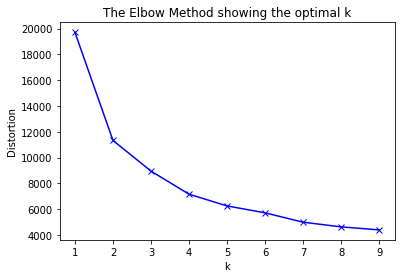

In [27]:
innout_grouped_clustering = CA_data_merged.drop('Restaurant_Address', 1)

# Determine best value for k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(innout_grouped_clustering)
    kmeanModel.fit(innout_grouped_clustering)
    distortions.append(sum(np.min(cdist(innout_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / innout_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**We're going to go with 4 as the optimal number for K.**

In [28]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(innout_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 2, 0, 2, 0, 3, 0], dtype=int32)

In [29]:
innout_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
innout_venues_sorted.head()

,Restaurant Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1010 Lakeville Hwy, Petaluma, CA",1,Convenience Store,Sandwich Place,Plaza,Thrift / Vintage Store,Pet Service,Shipping Store,Dog Run,Pizza Place,Hotel,Video Store
1,"10525 Carmenita Rd. Santa Fe Springs, CA",0,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Pharmacy,Pizza Place,Burger Joint,Thai Restaurant,Asian Restaurant,Convenience Store,Big Box Store
2,"10601 E. Lower Azusa Rd. Temple City, CA",1,Mexican Restaurant,Chinese Restaurant,Liquor Store,Pizza Place,Food,Tapas Restaurant,Market,Bar,Lounge,Hobby Shop
3,"1090 N. Western Ave. San Pedro, CA",1,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Grocery Store,Shipping Store,Clothing Store,Park,Bank,Multiplex,Sandwich Place
4,"11 Rollins Rd. Millbrae, CA",2,Chinese Restaurant,Hotel,Coffee Shop,Bakery,Shipping Store,Hotel Bar,Sandwich Place,Vietnamese Restaurant,Italian Restaurant,Sushi Restaurant


In [30]:
innout_location_data = dfs
innout_location_data.head()

,Address,Region,Rand_Sales,Zipcode,Latitude,Longitude,Median Income of Zip,Density of Zip
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654,53027,12101.0
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439,80183,5019.0
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529,55495,353.0
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629,51232,5699.0
4,"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575,40714,8521.0


In [31]:
innout_location_data = innout_location_data.rename(columns={'Address' : 'Restaurant Address'})
innout_location_data.head()

,Restaurant Address,Region,Rand_Sales,Zipcode,Latitude,Longitude,Median Income of Zip,Density of Zip
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654,53027,12101.0
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439,80183,5019.0
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529,55495,353.0
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629,51232,5699.0
4,"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575,40714,8521.0


In [32]:
innout_location_data = innout_location_data.set_index('Restaurant Address')
innout_venues_sorted = innout_venues_sorted.set_index('Restaurant Address')

In [33]:
CA_innout_final_merged = pd.merge(innout_location_data, innout_venues_sorted, left_index=True, right_index=True)
CA_innout_final_merged.head()

,Region,Rand_Sales,Zipcode,Latitude,Longitude,Median Income of Zip,Density of Zip,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Restaurant Address,,,,,,,,,,,,,,,,,,
"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654,53027,12101.0,3,Park,Liquor Store,Convenience Store,ATM,American Restaurant,Gym / Fitness Center,Mexican Restaurant,Coffee Shop,Pizza Place,Optical Shop
"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439,80183,5019.0,0,Hotel,Bank,American Restaurant,Mexican Restaurant,Coffee Shop,Trail,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Sandwich Place,Convenience Store
"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529,55495,353.0,2,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Hotel,Asian Restaurant,Liquor Store,Taco Place,Pharmacy,Park,Video Game Store
"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629,51232,5699.0,2,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Asian Restaurant,Miscellaneous Shop,American Restaurant,Grocery Store,Shipping Store
"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575,40714,8521.0,1,Burger Joint,Mexican Restaurant,Ice Cream Shop,American Restaurant,Japanese Restaurant,Sandwich Place,Sushi Restaurant,Bakery,Martial Arts Dojo,Pizza Place


In [34]:
CA_innout_final_merged = CA_innout_final_merged.reset_index()
CA_innout_final_merged.head()

,Restaurant Address,Region,Rand_Sales,Zipcode,Latitude,Longitude,Median Income of Zip,Density of Zip,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654,53027,12101.0,3,Park,Liquor Store,Convenience Store,ATM,American Restaurant,Gym / Fitness Center,Mexican Restaurant,Coffee Shop,Pizza Place,Optical Shop
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439,80183,5019.0,0,Hotel,Bank,American Restaurant,Mexican Restaurant,Coffee Shop,Trail,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Sandwich Place,Convenience Store
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529,55495,353.0,2,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Hotel,Asian Restaurant,Liquor Store,Taco Place,Pharmacy,Park,Video Game Store
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629,51232,5699.0,2,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Asian Restaurant,Miscellaneous Shop,American Restaurant,Grocery Store,Shipping Store
4,"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575,40714,8521.0,1,Burger Joint,Mexican Restaurant,Ice Cream Shop,American Restaurant,Japanese Restaurant,Sandwich Place,Sushi Restaurant,Bakery,Martial Arts Dojo,Pizza Place


**Ok, now that we have this dataframe ready, let's visualize the clusters.**

In [35]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CA_innout_final_merged['Latitude'], CA_innout_final_merged['Longitude'], CA_innout_final_merged['Restaurant Address'], CA_innout_final_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Now that we have our clusters, we should try and figure out which ones are going to be the most profitable.**

In [36]:
cluster_counts = CA_innout_final_merged.groupby('Cluster Labels').count()
cluster_counts = cluster_counts.rename(columns = {'Restaurant Address' : '# of Restaurants in Cluster'})
cluster_counts = cluster_counts.reset_index()
cluster_counts = cluster_counts[['Cluster Labels', '# of Restaurants in Cluster']]
cluster_counts

,Cluster Labels,# of Restaurants in Cluster
0,0,34
1,1,37
2,2,25
3,3,20


In [37]:
cluster_sums = CA_innout_final_merged.groupby('Cluster Labels')['Rand_Sales'].sum()
cluster_sums = cluster_sums.to_frame()
cluster_sums = cluster_sums.reset_index()
cluster_sums

,Cluster Labels,Rand_Sales
0,0,147291286
1,1,152682914
2,2,99691353
3,3,90638618


In [38]:
average_sales = pd.merge(cluster_counts, cluster_sums, left_index = True, right_index = True)
average_sales = average_sales.drop('Cluster Labels_y', 1)
average_sales = average_sales.rename(columns = {'Cluster Labels_x' : 'Cluster Labels'})
average_sales

,Cluster Labels,# of Restaurants in Cluster,Rand_Sales
0,0,34,147291286
1,1,37,152682914
2,2,25,99691353
3,3,20,90638618


In [39]:
average_sales['Average Yearly Sales of Restaurant in Cluster'] = average_sales['Rand_Sales'] / average_sales['# of Restaurants in Cluster']
average_sales.sort_values('Average Yearly Sales of Restaurant in Cluster', ascending = False)

,Cluster Labels,# of Restaurants in Cluster,Rand_Sales,Average Yearly Sales of Restaurant in Cluster
3,3,20,90638618,4.531931e+06
0,0,34,147291286,4.332097e+06
1,1,37,152682914,4.126565e+06
2,2,25,99691353,3.987654e+06


**Alright, so it looks like restaurants in Cluster 3 will be about USD 200k more profitable on average than restaurants in Cluster 0, which themselves are USD 200k more profitable than stores in Cluster 1. Cluster 2 restaurants are USD 600k less profitable than stores in Cluster 3. So, if In-N-Out is going to expand to Seattle (or anywhere else, for that matter), they should be doing it in areas that our model classifies ideally as being a part of Clusters 3 or 0. The next section will mine some data for the Seattle area.**

**Zip codes are an easy place to start, since they have a defined area and data about the median income and population density are readily available. We'll start with a list of zip codes for the Seattle-Tacoma-Everett MSA.**


In [40]:
s_path = 'Seattle_Zip_Codes.csv'

s_dfs = pd.read_csv(s_path, header=0)
print(s_dfs.shape)
print('There are {} unique Zip Codes.'.format(len(s_dfs['Seattle_Zip_Codes'].unique())))

(169, 1)
There are 169 unique Zip Codes.


**Now we'll go about building the dataframe in the same way that we did for the California In-N-Out data.** 

In [41]:
s_latlist = list()
s_lonlist = list()

for x in s_dfs['Seattle_Zip_Codes']:
    g = geocoder.arcgis(str(x))
    lat = g.lat
    s_latlist.append(lat)
    long = g.lng
    s_lonlist.append(long)

In [42]:
print("latlist length: ", len(s_latlist))
print("lonlist length: ", len(s_lonlist))

latlist length:  169
lonlist length:  169


In [43]:
s_lat_df = pd.DataFrame({'Latitude' : s_latlist})
s_lon_df = pd.DataFrame({'Longitude' : s_lonlist}) 
s_dfs = pd.merge(s_dfs, s_lat_df, left_index = True, right_index = True)
s_dfs = pd.merge(s_dfs, s_lon_df, left_index = True, right_index = True)
s_dfs.head()

,Seattle_Zip_Codes,Latitude,Longitude
0,98052,47.675035,-122.123781
1,98001,47.339915,-122.285840
2,98068,47.422258,-121.412711
3,98170,47.620320,-122.331790
4,98223,48.192544,-122.119878


In [44]:
from uszipcode import SearchEngine
s_income_list = []
s_density_list = []

for inc in s_dfs['Seattle_Zip_Codes']:
    inc = str(inc)
    search = SearchEngine(simple_zipcode=True)
    med_income = search.by_zipcode(inc)
    density = med_income.population_density
    med_income = med_income.median_household_income
    s_income_list.append(med_income)
    s_density_list.append(density)

s_inc_df = pd.DataFrame({'Median Income of Zip' : s_income_list}) 
s_dfs = pd.merge(s_dfs, s_inc_df, left_index = True, right_index = True)

s_dens_df = pd.DataFrame({'Density of Zip' : s_density_list})
s_dfs = pd.merge(s_dfs, s_dens_df, left_index = True, right_index = True)
print(s_dfs.shape)
print('There are {} unique Entries.'.format(len(s_dfs['Median Income of Zip'].unique())))
s_dfs

(169, 5)
There are 117 unique Entries.


,Seattle_Zip_Codes,Latitude,Longitude,Median Income of Zip,Density of Zip
0,98052,47.675035,-122.123781,99192.0,2908.0
1,98001,47.339915,-122.285840,71746.0,1717.0
2,98068,47.422258,-121.412711,65625.0,2.0
3,98170,47.620320,-122.331790,NaN,NaN
4,98223,48.192544,-122.119878,65863.0,128.0
5,98002,47.283170,-122.216980,43568.0,4423.0
6,98003,47.350185,-122.304999,45894.0,3800.0
7,98023,47.304750,-122.351275,67906.0,4604.0
8,98047,47.264360,-122.251260,52482.0,2616.0
9,98063,47.307120,-122.314200,NaN,NaN


These queries returned 117 rows with with both columns of demographic information fully filled. Because we want to avoid losing 30% of our datapoints if at all possible, we're going to fill in the missing data by hand, since it's only a few cells that need to be fixed. Any rows that we aren't able to fill out by looking in census databases or at arcgis will be deleted. Let's export the dataframe so that we can edit it.

In [51]:
s_dfs.to_csv('s_dfs_for_cleaning.csv')

Now that we've done the appropriate editing, we can bring the dataframe back in to do further work with it. 

In [45]:
s_path = 's_dfs_for_cleaning.csv'

s_dfs = pd.read_csv(s_path, header=0)
print(s_dfs.shape)
print('There are {} unique Zip Codes.'.format(len(s_dfs['Seattle_Zip_Codes'].unique())))

(166, 5)
There are 166 unique Zip Codes.


We ended up losing only 3 rows instead of around 50, which is fantastic. Let's make sure that there aren't anymore NaNs that we missed, and reindex the dataframe.

In [46]:
s_dfs = s_dfs.dropna()
s_dfs = s_dfs.set_index('Seattle_Zip_Codes')
s_dfs = s_dfs.reset_index()
s_dfs.head()

,Seattle_Zip_Codes,Latitude,Longitude,Median Income of Zip,Density of Zip
0,98001,47.339915,-122.285840,71746,1717
1,98002,47.283170,-122.216980,43568,4423
2,98003,47.350185,-122.304999,45894,3800
3,98004,47.615850,-122.196880,93521,3977
4,98005,47.622355,-122.158721,84774,2361


Awesome, now let's visualize these datapoints on a map.

In [47]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

import folium
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, address in zip(s_dfs['Latitude'], s_dfs['Longitude'], s_dfs['Seattle_Zip_Codes']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)

map_seattle

Now we're ready to query foursquare for the Seattle datapoints. We're going to modify the query language a little bit to increase the radius of the search, because we are assuming that most zip codes have a radius of more than 1000 meters. 

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000, LIMIT = 200):
    print("Query in progress! Please wait.")
    import requests
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip_Code', 
                  'Zip_Latitude', 
                  'Zip_Longitude', 
                  'Nearby_Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    print("Query complete!")
    return(nearby_venues)

In [49]:
s_zip_nearby_venues = getNearbyVenues(names=s_dfs['Seattle_Zip_Codes'],
                                   latitudes=s_dfs['Latitude'],
                                   longitudes=s_dfs['Longitude']
                                  )

Query in progress! Please wait.
Query complete!


Let's have a look at the dataframe that resulted from our query to look at the type of information returned, namely the names, locations, and categories of the venues nearby to the center of each Zip Code. 

In [50]:
s_zip_nearby_venues.head()

,Zip_Code,Zip_Latitude,Zip_Longitude,Nearby_Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,98001,47.339915,-122.28584,Jump Start Espresso,47.341826,-122.301238,Coffee Shop
1,98001,47.339915,-122.28584,Los Bigotes De Villa,47.328836,-122.311826,Mexican Restaurant
2,98001,47.339915,-122.28584,Kwan Tip Thai,47.337911,-122.311905,Thai Restaurant
3,98001,47.339915,-122.28584,Starbucks,47.343860,-122.311956,Coffee Shop
4,98001,47.339915,-122.28584,Star Lake Inn,47.353503,-122.289049,Bar


In [51]:
print(s_zip_nearby_venues.shape)

(12576, 7)


In [59]:
print('There are {} unique Zip Codes.'.format(len(s_zip_nearby_venues['Zip_Code'].unique())))
print('There are {} unique categories.'.format(len(s_zip_nearby_venues['Venue_Category'].unique())))
s_zip_nearby_venues.groupby('Zip_Code').count().head()

There are 166 unique Zip Codes.
There are 396 unique categories.


,Zip_Latitude,Zip_Longitude,Nearby_Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Zip_Code,,,,,,
98001,66,66,66,66,66,66
98002,100,100,100,100,100,100
98003,66,66,66,66,66,66
98004,100,100,100,100,100,100
98005,100,100,100,100,100,100


Let's perform the same kind of one-hot encoding that we did on the In-N-Out data. 

In [54]:
# one hot encoding
s_zip_onehot = pd.get_dummies(s_zip_nearby_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe and put it at the beginning of the dataframe. 
s_zip_onehot['Zip_Code'] = s_zip_nearby_venues['Zip_Code']
s_zip_onehot = s_zip_onehot.set_index('Zip_Code')
s_zip_onehot = s_zip_onehot.reset_index()

s_zip_onehot.head()

,Zip_Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,98001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can aggregate this into a pandas dataframe

In [57]:
s_zip_grouped = s_zip_onehot.groupby('Zip_Code').mean().reset_index()
s_zip_grouped['Zip_Code'] = s_zip_grouped['Zip_Code'].astype(str)
s_zip_grouped.head()

,Zip_Code,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,98001,0.015152,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
1,98002,0.000000,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.01,0.0,0.0,0.01,0.00,0.0,0.0
2,98003,0.015152,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
3,98004,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.01,0.0,0.0
4,98005,0.000000,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.0,0.0


If we are interested in seeing the top five venue types for each Zip Code, we can run this code. The next cell will do something similar, and put the results directly into a pandas dataframe. 

In [ ]:
#To visualize the top 5 venues from each Zip Code, un-comment this cell and run.
# num_top_venues = 5
# count = 0
# for code in s_zip_grouped['Zip_Code']:
#     print("----"+code+"----")
#     temp = s_zip_grouped[s_zip_grouped['Zip_Code'] == code].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')
#     count = count + 1
# print(count)

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip_Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
s_zip_venues_sorted = pd.DataFrame(columns=columns)
s_zip_venues_sorted['Zip_Code'] = s_zip_grouped['Zip_Code']

for ind in np.arange(s_zip_grouped.shape[0]):
    s_zip_venues_sorted.iloc[ind, 1:] = return_most_common_venues(s_zip_grouped.iloc[ind, :], num_top_venues)

s_zip_venues_sorted.head()

,Zip_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98001,Coffee Shop,Korean Restaurant,Grocery Store,Sandwich Place,Thai Restaurant,Pizza Place,Convenience Store,Gas Station,Hotel,Gym / Fitness Center
1,98002,Clothing Store,Coffee Shop,Sandwich Place,Pizza Place,Casino,Convenience Store,Italian Restaurant,Cosmetics Shop,Fast Food Restaurant,Lingerie Store
2,98003,Coffee Shop,Mexican Restaurant,Video Store,Grocery Store,Convenience Store,Pizza Place,Fast Food Restaurant,Pharmacy,Gas Station,Park
3,98004,Coffee Shop,Steakhouse,Grocery Store,Spa,Italian Restaurant,Toy / Game Store,Pizza Place,Sandwich Place,Bubble Tea Shop,Shopping Mall
4,98005,Coffee Shop,Gym,Gym / Fitness Center,Grocery Store,Pizza Place,Sporting Goods Shop,Bakery,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant


A stakeholder in this research might be interested to see these most common venues next to the demographic data we found, so let's create a table that contains all the relevant data. 

In [74]:
s_dem_data = s_dfs
s_dem_data = s_dem_data.rename(columns = {'Seattle_Zip_Codes' : 'Zip_Code'})
s_dem_data['Zip_Code'] = s_dem_data['Zip_Code'].astype(str)
s_dem_data = s_dem_data.set_index('Zip_Code')
s_dem_data.head()

,Latitude,Longitude,Median Income of Zip,Density of Zip
Zip_Code,,,,
98001,47.339915,-122.285840,71746,1717
98002,47.283170,-122.216980,43568,4423
98003,47.350185,-122.304999,45894,3800
98004,47.615850,-122.196880,93521,3977
98005,47.622355,-122.158721,84774,2361


In [70]:
s_venue_data = s_zip_venues_sorted
s_venue_data = s_venue_data.set_index('Zip_Code')
s_venue_data.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Zip_Code,,,,,,,,,,
98001,Coffee Shop,Korean Restaurant,Grocery Store,Sandwich Place,Thai Restaurant,Pizza Place,Convenience Store,Gas Station,Hotel,Gym / Fitness Center
98002,Clothing Store,Coffee Shop,Sandwich Place,Pizza Place,Casino,Convenience Store,Italian Restaurant,Cosmetics Shop,Fast Food Restaurant,Lingerie Store
98003,Coffee Shop,Mexican Restaurant,Video Store,Grocery Store,Convenience Store,Pizza Place,Fast Food Restaurant,Pharmacy,Gas Station,Park
98004,Coffee Shop,Steakhouse,Grocery Store,Spa,Italian Restaurant,Toy / Game Store,Pizza Place,Sandwich Place,Bubble Tea Shop,Shopping Mall
98005,Coffee Shop,Gym,Gym / Fitness Center,Grocery Store,Pizza Place,Sporting Goods Shop,Bakery,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant


In [79]:
s_venue_dem_merged = s_dem_data.merge(s_venue_data, left_on= 'Zip_Code', right_on = 'Zip_Code')
s_venue_dem_merged = s_venue_dem_merged.reset_index()
s_venue_dem_merged.head(10)

,Zip_Code,Latitude,Longitude,Median Income of Zip,Density of Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98001,47.339915,-122.285840,71746,1717,Coffee Shop,Korean Restaurant,Grocery Store,Sandwich Place,Thai Restaurant,Pizza Place,Convenience Store,Gas Station,Hotel,Gym / Fitness Center
1,98002,47.283170,-122.216980,43568,4423,Clothing Store,Coffee Shop,Sandwich Place,Pizza Place,Casino,Convenience Store,Italian Restaurant,Cosmetics Shop,Fast Food Restaurant,Lingerie Store
2,98003,47.350185,-122.304999,45894,3800,Coffee Shop,Mexican Restaurant,Video Store,Grocery Store,Convenience Store,Pizza Place,Fast Food Restaurant,Pharmacy,Gas Station,Park
3,98004,47.615850,-122.196880,93521,3977,Coffee Shop,Steakhouse,Grocery Store,Spa,Italian Restaurant,Toy / Game Store,Pizza Place,Sandwich Place,Bubble Tea Shop,Shopping Mall
4,98005,47.622355,-122.158721,84774,2361,Coffee Shop,Gym,Gym / Fitness Center,Grocery Store,Pizza Place,Sporting Goods Shop,Bakery,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant
5,98006,47.572650,-122.168850,110290,3402,Coffee Shop,Shoe Store,Sandwich Place,Pizza Place,Mexican Restaurant,Shipping Store,Asian Restaurant,Vietnamese Restaurant,Pharmacy,Burger Joint
6,98007,47.644430,-122.146140,73162,5684,Pizza Place,Coffee Shop,Gym,Chinese Restaurant,Thai Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Park,Sandwich Place
7,98008,47.620360,-122.125630,92986,4437,Coffee Shop,Thai Restaurant,Japanese Restaurant,Pizza Place,Chinese Restaurant,Gym / Fitness Center,Grocery Store,Mexican Restaurant,Vietnamese Restaurant,Toy / Game Store
8,98009,47.620650,-122.202770,97079,771,Steakhouse,Clothing Store,Spa,Coffee Shop,Sushi Restaurant,Pizza Place,Toy / Game Store,Bubble Tea Shop,Italian Restaurant,Mexican Restaurant
9,98010,47.312839,-122.004510,85398,334,Pizza Place,Trail,Brewery,Bakery,Playground,Athletics & Sports,American Restaurant,Bike Trail,Fish & Chips Shop,Filipino Restaurant


Alright, now that we've got that table set up, let's get ready to apply our model to the new dataset. This is going to require some additional wrangling for several reasons. Firstly, the .predict() method will not work if there are more inputs in the test dataframe than the model dataframe, so we're going to have to find the columns that these dataframes have in common, and then refit the model based on what these two places have in common. Then we'll be able to predict which places would be the best locations to put a new In-N-Out location. 

First, we need to build a dataframe for the Seattle datapoints that includes the Zip Code, the demographic data, and the numerical frequency data from our foursquare query. 

In [77]:
s_venue_numerical = s_zip_grouped
s_venue_numerical = s_venue_numerical.set_index('Zip_Code')
s_venue_numerical.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Zip_Code,,,,,,,,,,,,,,,,,,,,,
98001,0.015152,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
98002,0.000000,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.01,0.0,0.0,0.01,0.00,0.0,0.0
98003,0.015152,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
98004,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.01,0.0,0.0
98005,0.000000,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.0,0.0


In [82]:
s_inc_density = s_venue_dem_merged[['Zip_Code', 'Median Income of Zip', 'Density of Zip']]
s_inc_density = s_inc_density.set_index('Zip_Code')
s_inc_density.head()

,Median Income of Zip,Density of Zip
Zip_Code,,
98001,71746,1717
98002,43568,4423
98003,45894,3800
98004,93521,3977
98005,84774,2361


In [85]:
s_prelim_model = s_inc_density.merge(s_venue_numerical, left_on = 'Zip_Code', right_on = 'Zip_Code')
s_prelim_model = s_prelim_model.reset_index()
s_prelim_model.head()

,Zip_Code,Median Income of Zip,Density of Zip,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,98001,71746,1717,0.015152,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
1,98002,43568,4423,0.000000,0.01,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.01,0.0,0.0,0.01,0.00,0.0,0.0
2,98003,45894,3800,0.015152,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0
3,98004,93521,3977,0.000000,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.01,0.00,0.0,0.0,0.00,0.01,0.0,0.0
4,98005,84774,2361,0.000000,0.00,0.0,0.01,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.01,0.0,0.0


In [86]:
CA_data_merged.head()

,Restaurant_Address,Median Income of Zip,Density of Zip,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,...,Warehouse Store,Waste Facility,Water Park,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,"1210 N. Atlantic Blvd. Alhambra, CA",53027,12101.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,"420 N. Santa Anita Ave. Arcadia, CA",80183,5019.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,"324 S. Azusa Ave. Azusa, CA",55495,353.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,"13850 Francisquito Ave. Baldwin Park, CA",51232,5699.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0
4,"761 N. First St. Burbank, CA",40714,8521.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010101,0.0,0.0,0.0,0.0,0.0,0.0,0.020202,0.010101,0.0


Ok, let's find out what columns these two dataframes have in common. Then we can refit the model accordingly.

In [87]:
common_cols = list(set(CA_data_merged.columns).intersection(s_prelim_model.columns))
print(len(common_cols))

312


In [93]:
common_cols.sort()
common_cols[0:5]

['ATM',
 'Accessories Store',
 'Afghan Restaurant',
 'African Restaurant',
 'Airport']

Now that we've got all the common columns in a list, we can select the relevant data from the In-N-Out dataframe, CA_data_merged, refit the model, and make sure that nothing has changed. 

In [95]:
innout_grouped_clustering = CA_data_merged[common_cols]

# Determine best value for k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(innout_grouped_clustering)
    kmeanModel.fit(innout_grouped_clustering)
    distortions.append(sum(np.min(cdist(innout_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / innout_grouped_clustering.shape[0])

innout_grouped_clustering.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046875,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040816,0.0,...,0.020408,0.0,0.000000,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040404,0.0,...,0.010101,0.0,0.010101,0.0,0.0,0.0,0.0,0.020202,0.010101,0.0


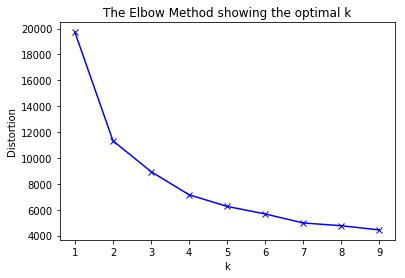

In [96]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Looks like 4 is still the optimal value for k. Let's refit the model and visualize the new clusters.

In [97]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(innout_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 2, 0, 2, 0, 3, 0], dtype=int32)

In [98]:
innout_venues_sorted.insert(1, 'Cluster Labels 2', kmeans.labels_)
innout_venues_sorted.head()

,Cluster Labels,Cluster Labels 2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Restaurant Address,,,,,,,,,,,,
"1010 Lakeville Hwy, Petaluma, CA",1,1,Convenience Store,Sandwich Place,Plaza,Thrift / Vintage Store,Pet Service,Shipping Store,Dog Run,Pizza Place,Hotel,Video Store
"10525 Carmenita Rd. Santa Fe Springs, CA",0,0,Mexican Restaurant,Sandwich Place,Fast Food Restaurant,Pharmacy,Pizza Place,Burger Joint,Thai Restaurant,Asian Restaurant,Convenience Store,Big Box Store
"10601 E. Lower Azusa Rd. Temple City, CA",1,1,Mexican Restaurant,Chinese Restaurant,Liquor Store,Pizza Place,Food,Tapas Restaurant,Market,Bar,Lounge,Hobby Shop
"1090 N. Western Ave. San Pedro, CA",1,1,Fast Food Restaurant,Mexican Restaurant,Pizza Place,Grocery Store,Shipping Store,Clothing Store,Park,Bank,Multiplex,Sandwich Place
"11 Rollins Rd. Millbrae, CA",2,2,Chinese Restaurant,Hotel,Coffee Shop,Bakery,Shipping Store,Hotel Bar,Sandwich Place,Vietnamese Restaurant,Italian Restaurant,Sushi Restaurant


In [99]:
innout_location_data = dfs

innout_location_data = innout_location_data.rename(columns={'Address' : 'Restaurant Address'})

innout_location_data = innout_location_data.set_index('Restaurant Address')

CA_innout_final_merged = pd.merge(innout_location_data, innout_venues_sorted, left_index=True, right_index=True)
CA_innout_final_merged = CA_innout_final_merged.reset_index()
CA_innout_final_merged.head()

,Restaurant Address,Region,Rand_Sales,Zipcode,Latitude,Longitude,Median Income of Zip,Density of Zip,Cluster Labels,Cluster Labels 2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1210 N. Atlantic Blvd. Alhambra, CA",LA,2581401,91801,34.106071,-118.134654,53027,12101.0,3,3,Park,Liquor Store,Convenience Store,ATM,American Restaurant,Gym / Fitness Center,Mexican Restaurant,Coffee Shop,Pizza Place,Optical Shop
1,"420 N. Santa Anita Ave. Arcadia, CA",LA,3843268,91006,34.145208,-118.031439,80183,5019.0,0,0,Hotel,Bank,American Restaurant,Mexican Restaurant,Coffee Shop,Trail,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Sandwich Place,Convenience Store
2,"324 S. Azusa Ave. Azusa, CA",LA,1722686,91702,34.117686,-117.907529,55495,353.0,2,2,Mexican Restaurant,Fast Food Restaurant,Convenience Store,Hotel,Asian Restaurant,Liquor Store,Taco Place,Pharmacy,Park,Video Game Store
3,"13850 Francisquito Ave. Baldwin Park, CA",LA,4850380,91706,34.068143,-117.973629,51232,5699.0,2,2,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Coffee Shop,Pharmacy,Asian Restaurant,Miscellaneous Shop,American Restaurant,Grocery Store,Shipping Store
4,"761 N. First St. Burbank, CA",LA,1117057,91502,34.185182,-118.315575,40714,8521.0,1,1,Burger Joint,Mexican Restaurant,Ice Cream Shop,American Restaurant,Japanese Restaurant,Sandwich Place,Sushi Restaurant,Bakery,Martial Arts Dojo,Pizza Place


Okay, now let's visualize the new map.

In [100]:
address = 'California'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CA_innout_final_merged['Latitude'], CA_innout_final_merged['Longitude'], CA_innout_final_merged['Restaurant Address'], CA_innout_final_merged['Cluster Labels 2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [101]:
cluster_counts = CA_innout_final_merged.groupby('Cluster Labels').count()
cluster_counts = cluster_counts.rename(columns = {'Restaurant Address' : '# of Restaurants in Cluster'})
cluster_counts = cluster_counts.reset_index()
cluster_counts = cluster_counts[['Cluster Labels', '# of Restaurants in Cluster']]
cluster_counts

,Cluster Labels,# of Restaurants in Cluster
0,0,34
1,1,37
2,2,25
3,3,20


In [102]:
cluster_sums = CA_innout_final_merged.groupby('Cluster Labels')['Rand_Sales'].sum()
cluster_sums = cluster_sums.to_frame()
cluster_sums = cluster_sums.reset_index()
cluster_sums

,Cluster Labels,Rand_Sales
0,0,147291286
1,1,152682914
2,2,99691353
3,3,90638618


In [103]:
average_sales = pd.merge(cluster_counts, cluster_sums, left_index = True, right_index = True)
average_sales = average_sales.drop('Cluster Labels_y', 1)
average_sales = average_sales.rename(columns = {'Cluster Labels_x' : 'Cluster Labels'})
average_sales

,Cluster Labels,# of Restaurants in Cluster,Rand_Sales
0,0,34,147291286
1,1,37,152682914
2,2,25,99691353
3,3,20,90638618


In [104]:
average_sales['Average Yearly Sales of Restaurant in Cluster'] = average_sales['Rand_Sales'] / average_sales['# of Restaurants in Cluster']
average_sales.sort_values('Average Yearly Sales of Restaurant in Cluster', ascending = False)

,Cluster Labels,# of Restaurants in Cluster,Rand_Sales,Average Yearly Sales of Restaurant in Cluster
3,3,20,90638618,4.531931e+06
0,0,34,147291286,4.332097e+06
1,1,37,152682914,4.126565e+06
2,2,25,99691353,3.987654e+06


Perfect, looks like we didn't lose much in eliminating those columns that the two dataframes didn't have in common; the order remains the same. Now we can move on to the actual prediction.

In [105]:
s_grouped_clustering = s_prelim_model[common_cols]
s_grouped_clustering.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,...,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,0.015152,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.015152,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
1,0.000000,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.010000,0.0,0.01,0.0,0.00,0.01,0.0,0.0,0.01,0.00
2,0.015152,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.015152,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
3,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,...,0.010000,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00,0.01
4,0.000000,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.030000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.01


In [110]:
cluster_labels = kmeans.predict(s_grouped_clustering)

In [111]:
s_cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Labels'])

In [113]:
s_cluster_labels.head()

,Cluster Labels
0,0
1,2
2,2
3,3
4,0


Now that we have our Seattle cluster labels, we can insert them into the s_venue_dem_merged dataframe that we made for our stakeholders.

In [114]:
s_venue_dem_merged.insert(5, 'Predicted Cluster', s_cluster_labels['Cluster Labels'])
# innout_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
# innout_venues_sorted.head()

In [115]:
s_venue_dem_merged.head()

,Zip_Code,Latitude,Longitude,Median Income of Zip,Density of Zip,Predicted Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98001,47.339915,-122.285840,71746,1717,0,Coffee Shop,Korean Restaurant,Grocery Store,Sandwich Place,Thai Restaurant,Pizza Place,Convenience Store,Gas Station,Hotel,Gym / Fitness Center
1,98002,47.283170,-122.216980,43568,4423,2,Clothing Store,Coffee Shop,Sandwich Place,Pizza Place,Casino,Convenience Store,Italian Restaurant,Cosmetics Shop,Fast Food Restaurant,Lingerie Store
2,98003,47.350185,-122.304999,45894,3800,2,Coffee Shop,Mexican Restaurant,Video Store,Grocery Store,Convenience Store,Pizza Place,Fast Food Restaurant,Pharmacy,Gas Station,Park
3,98004,47.615850,-122.196880,93521,3977,3,Coffee Shop,Steakhouse,Grocery Store,Spa,Italian Restaurant,Toy / Game Store,Pizza Place,Sandwich Place,Bubble Tea Shop,Shopping Mall
4,98005,47.622355,-122.158721,84774,2361,0,Coffee Shop,Gym,Gym / Fitness Center,Grocery Store,Pizza Place,Sporting Goods Shop,Bakery,Thai Restaurant,Chinese Restaurant,Vietnamese Restaurant


Let's go ahead and visualize the predicted clusters. 

In [117]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(s_venue_dem_merged['Latitude'], s_venue_dem_merged['Longitude'], s_venue_dem_merged['Zip_Code'], s_venue_dem_merged['Predicted Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now that we have the map, let's examine how many locations there are in each of the clustered groups. 

In [123]:
s_cluster_counts = s_venue_dem_merged.groupby('Predicted Cluster').count()
s_cluster_counts = s_cluster_counts.rename(columns = {'Zip_Code' : 'Predicted # of Zip Codes in Cluster'})
s_cluster_counts = s_cluster_counts.reset_index()
s_cluster_counts = s_cluster_counts[['Predicted Cluster', 'Predicted # of Zip Codes in Cluster']]
s_cluster_counts

,Predicted Cluster,Predicted # of Zip Codes in Cluster
0,0,50
1,1,57
2,2,23
3,3,36


Now, let's compare the two datasets to try and shed some light on whether Seattle might be a good market for In-N-Out to expand into.

| Cluster | Actual In-N-Out Grouping | Seattle Predicted Grouping |
|---------|--------------------------|----------------------------|
| Most Profitable | 20 (17.2%) | 36 (21.6%) |
| 2nd Most Profitable | 34 (29.3%) | 50 (30.1%) |
| 3rd Most Profitable | 37 (31.9%) | 57 (34.3%) |
| 4th Most Profitable | 25 (21.6%) | 23 ( 13.9%)| 

Several of these numbers are fairly promising. Per the predictions of the model, Seattle would have a higher number of locations which fall into the most profitable tier of stores, Cluster 3, when compared to California, where we already know these stores are extremely profitable. Seattle also edges out the current In-N-Out stores in our dataset for the next most profitable stores, if only by 0.8%. Seattle has more 3rd tier locations in the model than do the California data, but considerably fewer 4th tier locations. In light of this information, I would say that the risk is likely to be worth taking, and that the company should start scouting locations in the 1st tier zip codes. Interestingly, a majority of the top tier locations seem to be located in suburban or more rural areas, rather than being concentrated in the center of dense urban areas. This would seem to be consistent with the placement of many of the stores with which I am personally familiar in California. 

Thank you for viewing this lab!